## Pneumonia Classifier

This scripted was modeled using a few students' programs in the Make Money with Machine Learning course. I forget their user names... pranjalchaubey and florianrougier.... maybe a couple more. Sorry if I didn't mention you...

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

In [2]:
train_dir = '../Chest_Xrays_Images/chest_xray/train/'
validation_dir = '../Chest_Xrays_Images/chest_xray/val/'
test_dir = '../Chest_Xrays_Images/chest_xray/test/'

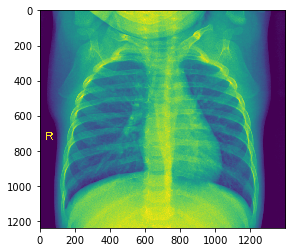

In [3]:
img = mpimg.imread(train_dir + 'NORMAL/IM-0500-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

### Showing examples of the images

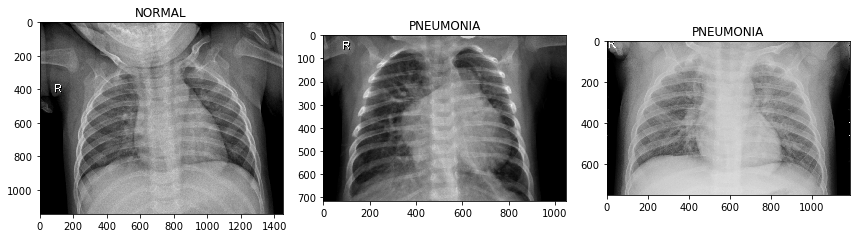

In [4]:
img_normal = plt.imread(train_dir + 'NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(train_dir + 'PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread(train_dir + 'PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

### Setting up the InceptionV3 model

In [5]:
K.clear_session()

NUM_CLASSES = 2


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

### Getting ready for optimization

In [6]:
optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### Normalizing the images

In [7]:
#creating black and white images
rescale = 1./255
#creating images that are 150 by 150
target_size = (150, 150)
batch_size = 128
#It is a categorical model...
class_mode = 'categorical'


train_datagen = ImageDataGenerator(rescale=rescale) #, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size, class_mode=class_mode,
                                                    batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, target_size=target_size, class_mode=class_mode,
                                                batch_size=batch_size, shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=target_size, class_mode=class_mode,
                                                  batch_size=batch_size, shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
#Checking the weights
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


In [9]:
# 10 epochs to give some time to train
# workers=12 for the 12 thread CPU i'm using
history = model.fit_generator(train_generator, epochs=10, validation_data=val_generator, 
                              class_weight=train_class_weights, workers=12, verbose=1,
                              steps_per_epoch=len(train_generator),validation_steps=len(val_generator))

MODEL_FILE = 'pneumonia_model.h5'
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
41/41 [==============================] - 41s 989ms/step - loss: 0.5712 - acc: 0.7308 - val_loss: 0.7298 - val_acc: 0.5000
Epoch 2/10
41/41 [==============================] - 12s 285ms/step - loss: 0.3945 - acc: 0.8229 - val_loss: 0.7744 - val_acc: 0.6875
Epoch 3/10
41/41 [==============================] - 13s 318ms/step - loss: 0.2795 - acc: 0.8926 - val_loss: 1.7729 - val_acc: 0.5000
Epoch 4/10
41/41 [==============================] - 13s 329ms/step - loss: 0.2331 - acc: 0.9093 - val_loss: 1.1005 - val_acc: 0.6875
Epoch 5/10
41/41 [==============================] - 13s 319ms/step - loss: 0.2171 - acc: 0.9139 - val_loss: 0.8967 - val_acc: 0.7500
Epoch 6/10
41/41 [==============================] - 13s 327ms/step - loss: 0.2037 - acc: 0.9210 - val_loss: 0.8415 - val_acc: 0.7500
Epoch 7/10
41/41 [==============================] - 13s 328ms/step - loss: 0.1869 - acc: 0.9243 - val_loss: 1.0282 - val_acc: 0.6250
Epoch 8/10
41/41 [===

In [10]:
val_loss, val_accuracy = model.evaluate_generator(val_generator)

In [11]:
print("Accuracy after transfer learning: {}".format(val_accuracy))

Accuracy after transfer learning: 0.8125


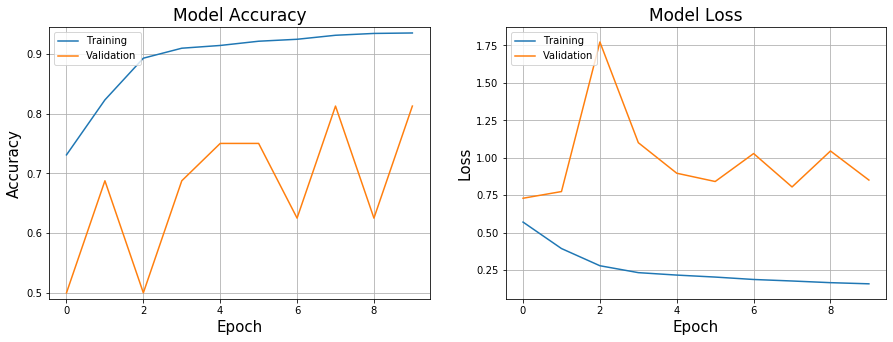

In [12]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [13]:
MODEL_FILE = f'C:/Users/ZAP-DS/Desktop/DataScience/Siraj-make-money/Week4/{MODEL_FILE}'
model = tf.keras.models.load_model(MODEL_FILE)

In [14]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

5/5 [==============================] - 7s 1s/step - loss: 1.0579 - acc: 0.7083
Loss     : 1.06  
Accuracy : 70.83%


In [15]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

5/5 [==============================] - 6s 1s/step


In [16]:
import random

num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 128
-----------------------------------
Accuracy                : 70.83%
-----------------------------------


In [17]:
test_generator.reset()
filenames = test_generator.filenames
#nb_samples = np.ceil(nb_samples/len(filenames))

predict = model.predict_generator(test_generator) #, steps=nb_samples)

In [18]:
import pandas as pd

predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

results

,Filename,Predictions
0,NORMAL\IM-0001-0001.jpeg,PNEUMONIA
1,NORMAL\IM-0003-0001.jpeg,NORMAL
2,NORMAL\IM-0005-0001.jpeg,NORMAL
3,NORMAL\IM-0006-0001.jpeg,NORMAL
4,NORMAL\IM-0007-0001.jpeg,NORMAL
...,...,...
619,PNEUMONIA\person96_bacteria_465.jpeg,PNEUMONIA
620,PNEUMONIA\person96_bacteria_466.jpeg,PNEUMONIA
621,PNEUMONIA\person97_bacteria_468.jpeg,PNEUMONIA
622,PNEUMONIA\person99_bacteria_473.jpeg,PNEUMONIA


In [19]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

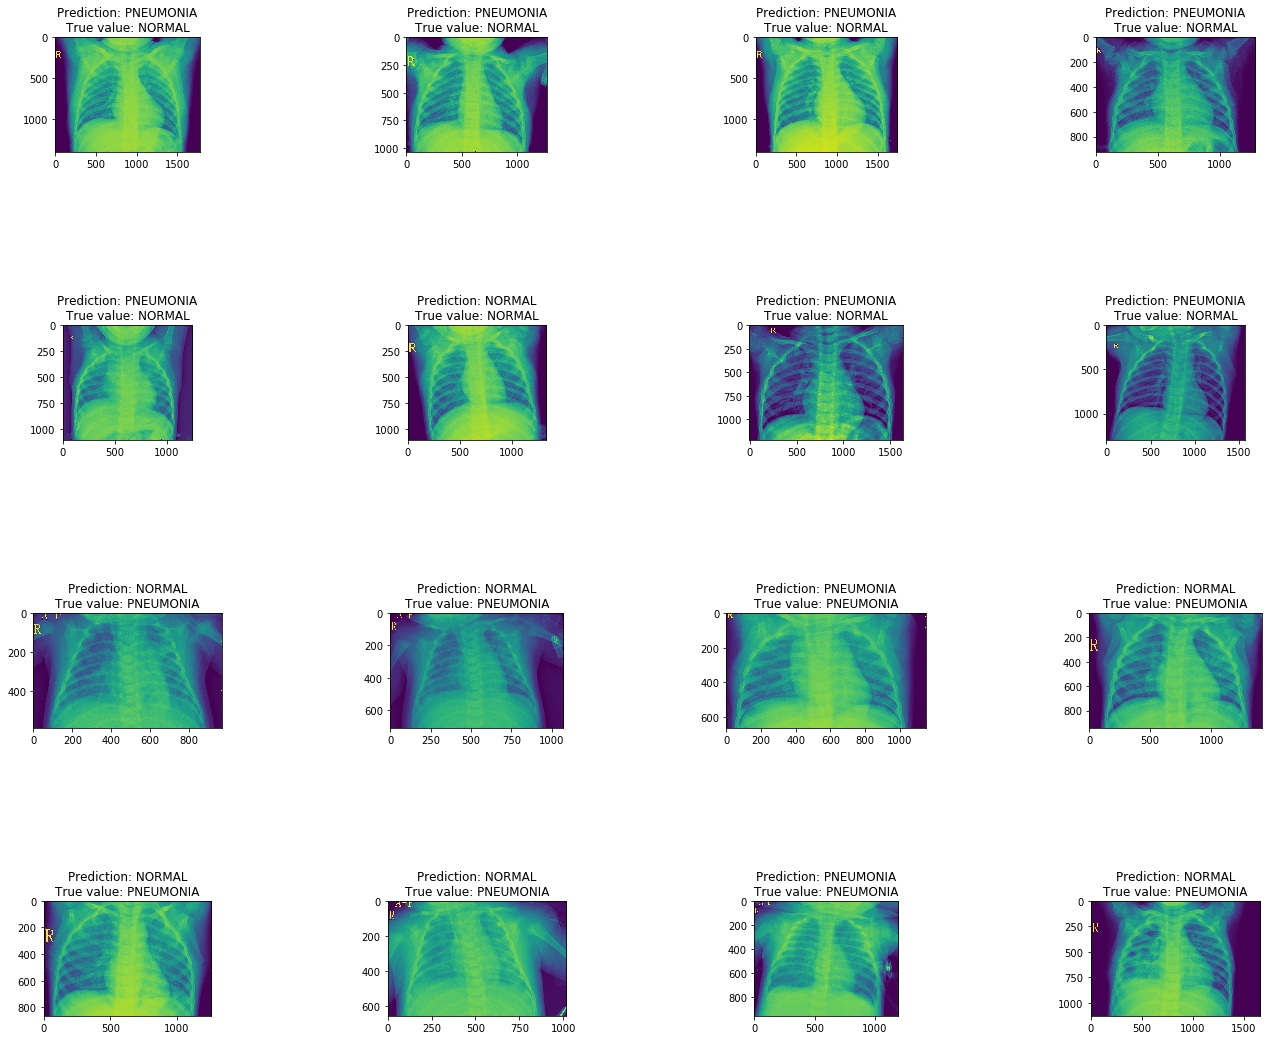

In [20]:
compare_results(validation_dir, val_generator)

In [21]:
import json
# serialize model to JSON
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

160756

Saved model to disk


In [22]:
model.trainable = True

In [23]:
print("Number of layers in the base model: {}".format(len(model.layers)))

Number of layers in the base model: 319


In [24]:
fine_tune_at = 200

In [25]:
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [26]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
model.fit_generator(generator = train_generator, epochs = 5, validation_data = val_generator, workers=12)

Epoch 1/5
41/41 [==============================] - 15s 355ms/step - loss: 0.1636 - acc: 0.9356 - val_loss: 1.2045 - val_acc: 0.6875
Epoch 2/5
41/41 [==============================] - 12s 284ms/step - loss: 0.1514 - acc: 0.9433 - val_loss: 1.4498 - val_acc: 0.6875
Epoch 3/5
41/41 [==============================] - 13s 327ms/step - loss: 0.1504 - acc: 0.9411 - val_loss: 0.9736 - val_acc: 0.8125
Epoch 4/5
41/41 [==============================] - 14s 333ms/step - loss: 0.1455 - acc: 0.9448 - val_loss: 1.0533 - val_acc: 0.7500
Epoch 5/5
41/41 [==============================] - 13s 321ms/step - loss: 0.1381 - acc: 0.9459 - val_loss: 1.2037 - val_acc: 0.7500


In [28]:
val_loss, val_accuracy = model.evaluate_generator(val_generator)

In [31]:
print("Validation accuracy: {}".format(val_accuracy))

Validation accuracy: 0.75


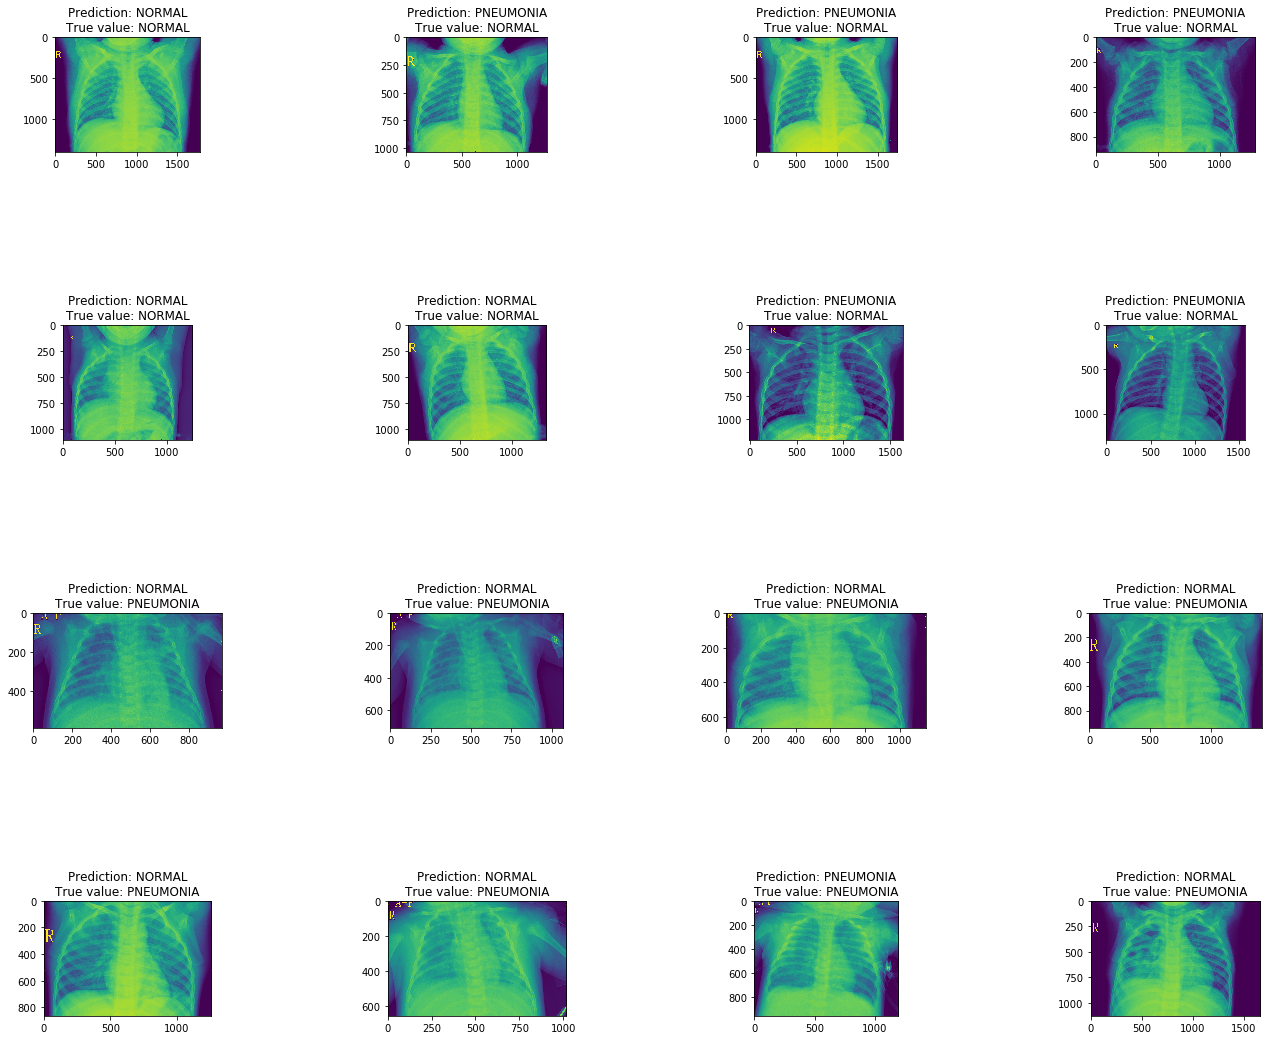

In [30]:
compare_results(validation_dir, val_generator)